# Training

**Goal:** To derive predictions from the dataset using the following models:
- XGBoost
- Logistic Regression
- Support Vector Machines (SVM)
- Random Forest
- K-Nearest Neighbors
- Neural Networks

The final model will be an ensemble of the best performing models.

**Load Data**

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv("../data/knight_hacks_dues_processed.csv")

# Convert class to a numeric value for use with Logistic Regression
for i, val in enumerate(data["class"]):
    if val == "Freshman":
        data.at[i, "class"] = 1
    elif val == "Sophomore":
        data.at[i, "class"] = 2
    elif val == "Junior":
        data.at[i, "class"] = 3
    elif val == "Senior":
        data.at[i, "class"] = 4
    else:
        data.at[i, "class"] = 5

data["class"] = data["class"].astype(int)

# Set features and target
drop = ["y_paid_dues", "school_grouped", "major_grouped"]

X = data.drop(columns=drop)
y = data["y_paid_dues"]

# Prefers XGBoost: 10
# Prefers Logistic Regression: 99
seed = None

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**XGBoost**

In [2]:
# Optimize hyperparameters - compare no balancing, class-weighting, and SMOTE
from imblearn.over_sampling import SMOTE

# Calculate scale_pos_weight to handle class imbalance
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight = count_neg / count_pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}\n")

param_list = {
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'max_depth': list(range(1,12)),
    "lambda": list(range(0,5)),
    "alpha": list(range(0,5)),
    'eta': list(np.linspace(0, 1, 10)),
    'min_child_weight': list(range(0,5)),
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none = xgb.XGBClassifier()
gscv_none = GridSearchCV(model_none, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
gscv_cw = GridSearchCV(model_cw, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = xgb.XGBClassifier()  # No scale_pos_weight needed
gscv_smote = GridSearchCV(model_smote, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote.fit(X_train_smote, y_train_smote)
print(f"Best CV F1 Score (SMOTE): {gscv_smote.best_score_:.4f}")

# Choose the best approach based on F1 score
scores = {
    'none': gscv_none.best_score_,
    'class_weight': gscv_cw.best_score_,
    'smote': gscv_smote.best_score_
}
best_method = max(scores, key=scores.get)
best_score = scores[best_method]

print(f"\n{'='*50}")
print(f"Best approach: {best_method.upper()} (F1: {best_score:.4f})")
print(f"{'='*50}")

if best_method == 'none':
    gscv = gscv_none
    X_train_final = X_train
    y_train_final = y_train
    best_params = gscv_none.best_params_.copy()
    scale_pos_weight_final = None
    use_smote = False
    balance_method = 'None'
elif best_method == 'class_weight':
    gscv = gscv_cw
    X_train_final = X_train
    y_train_final = y_train
    best_params = gscv_cw.best_params_.copy()
    scale_pos_weight_final = scale_pos_weight
    use_smote = False
    balance_method = 'Class-weighting'
else:  # smote
    gscv = gscv_smote
    X_train_final = X_train_smote
    y_train_final = y_train_smote
    best_params = gscv_smote.best_params_.copy()
    scale_pos_weight_final = None
    use_smote = True
    balance_method = 'SMOTE'

print("\nBest Parameters:", best_params)

Scale Pos Weight: 1.94

Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.6432

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6602

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8167

Best approach: SMOTE (F1: 0.8167)

Best Parameters: {'alpha': 3, 'eta': np.float64(0.8888888888888888), 'eval_metric': 'auc', 'lambda': 0, 'max_depth': 4, 'min_child_weight': 3, 'objective': 'binary:logistic'}


XGBoost Val Accuracy: 0.7197
XGBoost Test Accuracy: 0.7333
XGBoost Test F1: 0.5692
Balancing Method: SMOTE


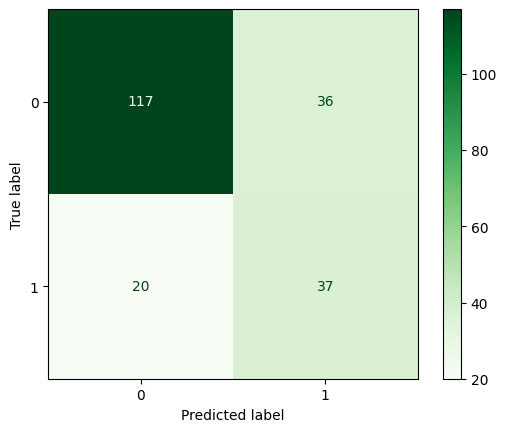

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Train final model with best approach
if scale_pos_weight_final:
    xg_model = xgb.XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight_final)
else:
    xg_model = xgb.XGBClassifier(**best_params)
xg_model.fit(X_train_final, y_train_final)

xg_pred_v = xg_model.predict(X_val)
xg_pred_ts = xg_model.predict(X_test)

xg_acc_v = accuracy_score(y_val, xg_pred_v)
xg_acc_ts = accuracy_score(y_test, xg_pred_ts)
xg_f1_ts = f1_score(y_test, xg_pred_ts)
print(f"XGBoost Val Accuracy: {xg_acc_v:.4f}")
print(f"XGBoost Test Accuracy: {xg_acc_ts:.4f}")
print(f"XGBoost Test F1: {xg_f1_ts:.4f}")
print(f"Balancing Method: {balance_method}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, xg_pred_ts), display_labels=xg_model.classes_)
cf.plot(cmap=plt.cm.Greens)

**Logistic Regression**

In [4]:
param_list = {
    "C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
    "penalty": ['l1', 'l2', 'elasticnet', None],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'saga'],
    "max_iter": [3000]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_lr = LogisticRegression()
gscv_none_lr = GridSearchCV(model_none_lr, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_lr.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_lr.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw_lr = LogisticRegression(class_weight='balanced')
gscv_cw_lr = GridSearchCV(model_cw_lr, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw_lr.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw_lr.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_lr, y_train_smote_lr = smote.fit_resample(X_train, y_train)
model_smote_lr = LogisticRegression()  # No class_weight needed
gscv_smote_lr = GridSearchCV(model_smote_lr, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_lr.fit(X_train_smote_lr, y_train_smote_lr)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_lr.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_lr = {
    'none': gscv_none_lr.best_score_,
    'class_weight': gscv_cw_lr.best_score_,
    'smote': gscv_smote_lr.best_score_
}
best_method_lr = max(scores_lr, key=scores_lr.get)
best_score_lr = scores_lr[best_method_lr]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_lr.upper()} (F1: {best_score_lr:.4f})")
print(f"{'='*50}")

if best_method_lr == 'none':
    gscv_lr = gscv_none_lr
    X_train_final_lr = X_train
    y_train_final_lr = y_train
    best_params_lr = gscv_none_lr.best_params_.copy()
    class_weight_final = None
    use_smote_lr = False
    balance_method_lr = 'None'
elif best_method_lr == 'class_weight':
    gscv_lr = gscv_cw_lr
    X_train_final_lr = X_train
    y_train_final_lr = y_train
    best_params_lr = gscv_cw_lr.best_params_.copy()
    class_weight_final = 'balanced'
    use_smote_lr = False
    balance_method_lr = 'Class-weighting'
else:  # smote
    gscv_lr = gscv_smote_lr
    X_train_final_lr = X_train_smote_lr
    y_train_final_lr = y_train_smote_lr
    best_params_lr = gscv_smote_lr.best_params_.copy()
    class_weight_final = None
    use_smote_lr = True
    balance_method_lr = 'SMOTE'

print("\nBest Parameters:", best_params_lr)

Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.5667

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6348

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.7261

Best approach: SMOTE (F1: 0.7261)

Best Parameters: {'C': 0.1, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}


Logistic Regression Val Accuracy: 0.7134
Logistic Regression Test Accuracy: 0.7952
Logistic Regression Test F1: 0.6767
Balancing Method: SMOTE


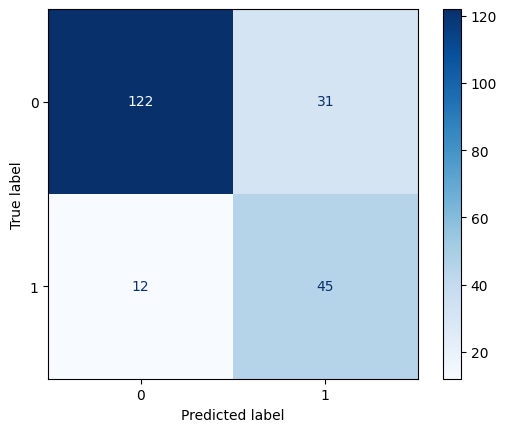

In [5]:
from sklearn.metrics import f1_score

# Train final model with best approach
if class_weight_final:
    lr_model = LogisticRegression(**best_params_lr, class_weight=class_weight_final)
else:
    lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_final_lr, y_train_final_lr)

lr_pred_v = lr_model.predict(X_val)
lr_pred_ts = lr_model.predict(X_test)

lr_acc_v = accuracy_score(y_val, lr_pred_v)
lr_acc_ts = accuracy_score(y_test, lr_pred_ts)
lr_f1_ts = f1_score(y_test, lr_pred_ts)
print(f"Logistic Regression Val Accuracy: {lr_acc_v:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_acc_ts:.4f}")
print(f"Logistic Regression Test F1: {lr_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_lr}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lr_pred_ts), display_labels=lr_model.classes_)
cf.plot(cmap=plt.cm.Blues)

**SVM**


In [6]:
param_list_svm = {
    "C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
    "kernel": ['linear', 'rbf', 'poly'],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1],
    "degree": [2, 3, 4],  # Only used for poly kernel
    "max_iter": [1000, 3000]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_svm = SVC()
gscv_none_svm = GridSearchCV(model_none_svm, param_list_svm, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_svm.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_svm.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw_svm = SVC(class_weight='balanced')
gscv_cw_svm = GridSearchCV(model_cw_svm, param_list_svm, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw_svm.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw_svm.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_svm, y_train_smote_svm = smote.fit_resample(X_train, y_train)
model_smote_svm = SVC()  # No class_weight needed
gscv_smote_svm = GridSearchCV(model_smote_svm, param_list_svm, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_svm.fit(X_train_smote_svm, y_train_smote_svm)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_svm.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_svm = {
    'none': gscv_none_svm.best_score_,
    'class_weight': gscv_cw_svm.best_score_,
    'smote': gscv_smote_svm.best_score_
}
best_method_svm = max(scores_svm, key=scores_svm.get)
best_score_svm = scores_svm[best_method_svm]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_svm.upper()} (F1: {best_score_svm:.4f})")
print(f"{'='*50}")

if best_method_svm == 'none':
    gscv_svm = gscv_none_svm
    X_train_final_svm = X_train
    y_train_final_svm = y_train
    best_params_svm = gscv_none_svm.best_params_.copy()
    class_weight_final_svm = None
    use_smote_svm = False
    balance_method_svm = 'None'
elif best_method_svm == 'class_weight':
    gscv_svm = gscv_cw_svm
    X_train_final_svm = X_train
    y_train_final_svm = y_train
    best_params_svm = gscv_cw_svm.best_params_.copy()
    class_weight_final_svm = 'balanced'
    use_smote_svm = False
    balance_method_svm = 'Class-weighting'
else:  # smote
    gscv_svm = gscv_smote_svm
    X_train_final_svm = X_train_smote_svm
    y_train_final_svm = y_train_smote_svm
    best_params_svm = gscv_smote_svm.best_params_.copy()
    class_weight_final_svm = None
    use_smote_svm = True
    balance_method_svm = 'SMOTE'

print("\nBest Parameters:", best_params_svm)


Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.5846

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6328

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8003

Best approach: SMOTE (F1: 0.8003)

Best Parameters: {'C': 2, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 1000}


SVM Val Accuracy: 0.7197
SVM Test Accuracy: 0.7143
SVM Test F1: 0.5775
Balancing Method: SMOTE


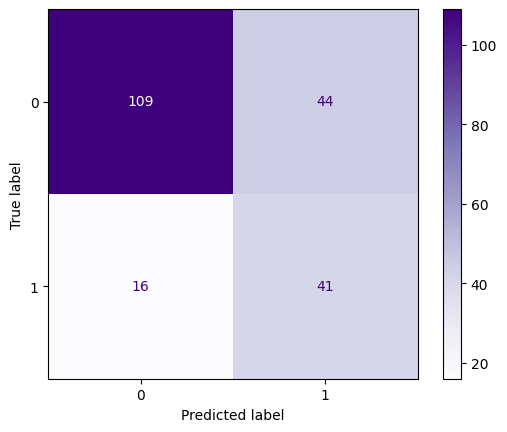

In [7]:
# Train final model with best approach
if class_weight_final_svm:
    svm_model = SVC(**best_params_svm, class_weight=class_weight_final_svm)
else:
    svm_model = SVC(**best_params_svm)
svm_model.fit(X_train_final_svm, y_train_final_svm)

svm_pred_v = svm_model.predict(X_val)
svm_pred_ts = svm_model.predict(X_test)

svm_acc_v = accuracy_score(y_val, svm_pred_v)
svm_acc_ts = accuracy_score(y_test, svm_pred_ts)
svm_f1_ts = f1_score(y_test, svm_pred_ts)
print(f"SVM Val Accuracy: {svm_acc_v:.4f}")
print(f"SVM Test Accuracy: {svm_acc_ts:.4f}")
print(f"SVM Test F1: {svm_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_svm}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, svm_pred_ts), display_labels=svm_model.classes_)
cf.plot(cmap=plt.cm.Purples)


**Random Forest**


In [10]:
param_list_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', None],
    "bootstrap": [True, False]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_rf = RandomForestClassifier(random_state=42)
gscv_none_rf = GridSearchCV(model_none_rf, param_list_rf, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_rf.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_rf.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gscv_cw_rf = GridSearchCV(model_cw_rf, param_list_rf, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw_rf.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw_rf.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_rf, y_train_smote_rf = smote.fit_resample(X_train, y_train)
model_smote_rf = RandomForestClassifier(random_state=42)  # No class_weight needed
gscv_smote_rf = GridSearchCV(model_smote_rf, param_list_rf, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_rf.fit(X_train_smote_rf, y_train_smote_rf)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_rf.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_rf = {
    'none': gscv_none_rf.best_score_,
    'class_weight': gscv_cw_rf.best_score_,
    'smote': gscv_smote_rf.best_score_
}
best_method_rf = max(scores_rf, key=scores_rf.get)
best_score_rf = scores_rf[best_method_rf]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_rf.upper()} (F1: {best_score_rf:.4f})")
print(f"{'='*50}")

if best_method_rf == 'none':
    gscv_rf = gscv_none_rf
    X_train_final_rf = X_train
    y_train_final_rf = y_train
    best_params_rf = gscv_none_rf.best_params_.copy()
    class_weight_final_rf = None
    use_smote_rf = False
    balance_method_rf = 'None'
elif best_method_rf == 'class_weight':
    gscv_rf = gscv_cw_rf
    X_train_final_rf = X_train
    y_train_final_rf = y_train
    best_params_rf = gscv_cw_rf.best_params_.copy()
    class_weight_final_rf = 'balanced'
    use_smote_rf = False
    balance_method_rf = 'Class-weighting'
else:  # smote
    gscv_rf = gscv_smote_rf
    X_train_final_rf = X_train_smote_rf
    y_train_final_rf = y_train_smote_rf
    best_params_rf = gscv_smote_rf.best_params_.copy()
    class_weight_final_rf = None
    use_smote_rf = True
    balance_method_rf = 'SMOTE'

print("\nBest Parameters:", best_params_rf)


Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.6867

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6680

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8442

Best approach: SMOTE (F1: 0.8442)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Random Forest Val Accuracy: 0.7389
Random Forest Test Accuracy: 0.7667
Random Forest Test F1: 0.6370
Balancing Method: SMOTE


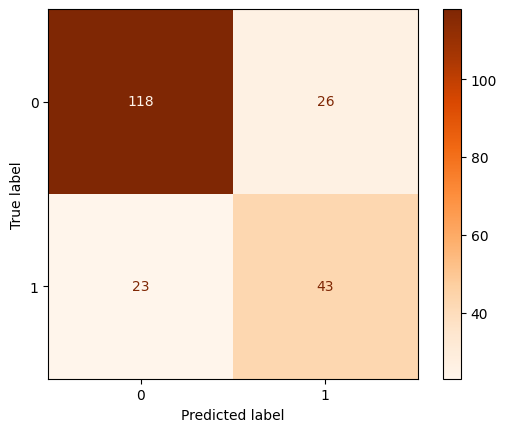

In [11]:
# Train final model with best approach
if class_weight_final_rf:
    rf_model = RandomForestClassifier(**best_params_rf, class_weight=class_weight_final_rf, random_state=42)
else:
    rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
rf_model.fit(X_train_final_rf, y_train_final_rf)

rf_pred_v = rf_model.predict(X_val)
rf_pred_ts = rf_model.predict(X_test)

rf_acc_v = accuracy_score(y_val, rf_pred_v)
rf_acc_ts = accuracy_score(y_test, rf_pred_ts)
rf_f1_ts = f1_score(y_test, rf_pred_ts)
print(f"Random Forest Val Accuracy: {rf_acc_v:.4f}")
print(f"Random Forest Test Accuracy: {rf_acc_ts:.4f}")
print(f"Random Forest Test F1: {rf_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_rf}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rf_pred_ts), display_labels=rf_model.classes_)
cf.plot(cmap=plt.cm.Oranges)


**K-Nearest Neighbors (KNN)**

Note: Features are already scaled using StandardScaler in the data loading cell, which is critical for distance-based algorithms like KNN.


In [13]:
param_list_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan', 'minkowski'],
    "p": [1, 2]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_knn = KNeighborsClassifier()
gscv_none_knn = GridSearchCV(model_none_knn, param_list_knn, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_knn.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_knn.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_knn, y_train_smote_knn = smote.fit_resample(X_train, y_train)
model_smote_knn = KNeighborsClassifier()
gscv_smote_knn = GridSearchCV(model_smote_knn, param_list_knn, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_knn.fit(X_train_smote_knn, y_train_smote_knn)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_knn.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_knn = {
    'none': gscv_none_knn.best_score_,
    'smote': gscv_smote_knn.best_score_
}
best_method_knn = max(scores_knn, key=scores_knn.get)
best_score_knn = scores_knn[best_method_knn]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_knn.upper()} (F1: {best_score_knn:.4f})")
print(f"{'='*50}")

if best_method_knn == 'none':
    gscv_knn = gscv_none_knn
    X_train_final_knn = X_train
    y_train_final_knn = y_train
    best_params_knn = gscv_none_knn.best_params_.copy()
    use_smote_knn = False
    balance_method_knn = 'None'
else:  # smote
    gscv_knn = gscv_smote_knn
    X_train_final_knn = X_train_smote_knn
    y_train_final_knn = y_train_smote_knn
    best_params_knn = gscv_smote_knn.best_params_.copy()
    use_smote_knn = True
    balance_method_knn = 'SMOTE'

print("\nBest Parameters:", best_params_knn)


Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.5710

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8326

Best approach: SMOTE (F1: 0.8326)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


KNN Val Accuracy: 0.6752
KNN Test Accuracy: 0.7143
KNN Test F1: 0.5652
Balancing Method: SMOTE
Optimal K: 3


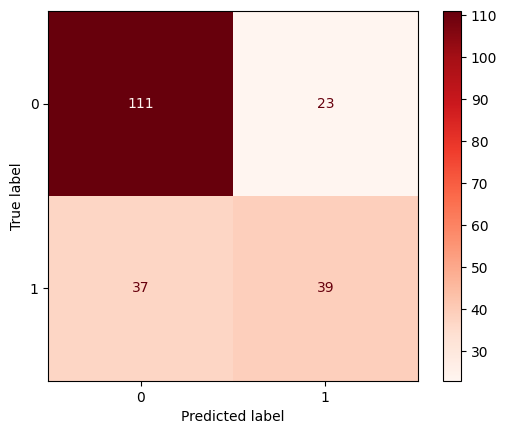

In [14]:
# Train final model with best approach
knn_model = KNeighborsClassifier(**best_params_knn)
knn_model.fit(X_train_final_knn, y_train_final_knn)

knn_pred_v = knn_model.predict(X_val)
knn_pred_ts = knn_model.predict(X_test)

knn_acc_v = accuracy_score(y_val, knn_pred_v)
knn_acc_ts = accuracy_score(y_test, knn_pred_ts)
knn_f1_ts = f1_score(y_test, knn_pred_ts)
print(f"KNN Val Accuracy: {knn_acc_v:.4f}")
print(f"KNN Test Accuracy: {knn_acc_ts:.4f}")
print(f"KNN Test F1: {knn_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_knn}")
print(f"Optimal K: {best_params_knn['n_neighbors']}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, knn_pred_ts), display_labels=knn_model.classes_)
cf.plot(cmap=plt.cm.Reds)


**Ensemble Model**

Combining predictions from all trained models using soft voting...

Model weights (based on val F1): XGB=0.182, LR=0.186, SVM=0.229, RF=0.193, KNN=0.210

Validation F1 Scores:
  Equal weights:     0.8271
  Weighted by F1:    0.8244

Best strategy (validation): Equal weights (F1: 0.8271)

ENSEMBLE STRATEGIES COMPARISON (Test F1 Scores)
Equal weights:        0.6415
Weighted by F1:       0.6497

Best strategy: Weighted by F1 (F1: 0.6497)
Ensemble Test Accuracy: 0.7381
Ensemble Test F1: 0.6497


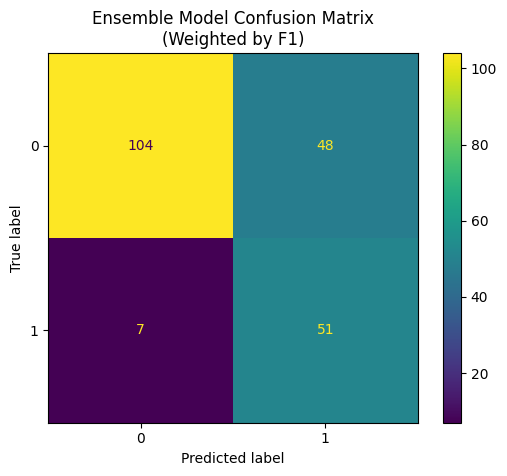


MODEL COMPARISON (Test F1 Scores)
XGBoost:              0.5692
Logistic Regression:  0.6767
SVM:                  0.5775
Random Forest:        0.6370
KNN:                  0.5652
Ensemble (Weighted by F1): 0.6497 ⭐


In [ ]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

print("Combining predictions from all trained models using soft voting...")

# Get probability predictions from all already-trained models (validation set)
xg_proba_val = xg_model.predict_proba(X_val)[:, 1]
lr_proba_val = lr_model.predict_proba(X_val)[:, 1]
# SVM: Check if predict_proba is available, otherwise use decision_function
try:
    svm_proba_val = svm_model.predict_proba(X_val)[:, 1]
except AttributeError:
    # Convert decision_function scores to probabilities using sigmoid
    from scipy.special import expit
    svm_scores_val = svm_model.decision_function(X_val)
    svm_proba_val = expit(svm_scores_val)  # Sigmoid transformation
rf_proba_val = rf_model.predict_proba(X_val)[:, 1]
knn_proba_val = knn_model.predict_proba(X_val)[:, 1]

# Try different ensemble strategies
# Strategy 1: Equal weights
ensemble_proba_val_equal = np.mean([xg_proba_val, lr_proba_val, svm_proba_val, 
                                     rf_proba_val, knn_proba_val], axis=0)
ensemble_pred_val_equal = (ensemble_proba_val_equal > 0.5).astype(int)
ensemble_f1_val_equal = f1_score(y_val, ensemble_pred_val_equal)

# Strategy 2: Weighted by individual model F1 scores
# Get validation F1 scores for weighting
xg_f1_val = f1_score(y_val, xg_model.predict(X_val))
lr_f1_val = f1_score(y_val, lr_model.predict(X_val))
svm_f1_val = f1_score(y_val, svm_model.predict(X_val))
rf_f1_val = f1_score(y_val, rf_model.predict(X_val))
knn_f1_val = f1_score(y_val, knn_model.predict(X_val))

weights = np.array([xg_f1_val, lr_f1_val, svm_f1_val, rf_f1_val, knn_f1_val])
weights = weights / weights.sum()  # Normalize to sum to 1
print(f"\nModel weights (based on val F1): XGB={weights[0]:.3f}, LR={weights[1]:.3f}, "
      f"SVM={weights[2]:.3f}, RF={weights[3]:.3f}, KNN={weights[4]:.3f}")

ensemble_proba_val_weighted = (xg_proba_val * weights[0] + lr_proba_val * weights[1] + 
                                svm_proba_val * weights[2] + rf_proba_val * weights[3] + 
                                knn_proba_val * weights[4])
ensemble_pred_val_weighted = (ensemble_proba_val_weighted > 0.5).astype(int)
ensemble_f1_val_weighted = f1_score(y_val, ensemble_pred_val_weighted)

# Choose best strategy for validation
strategies = {
    'Equal weights': ensemble_f1_val_equal,
    'Weighted by F1': ensemble_f1_val_weighted
}
best_strategy_val = max(strategies, key=strategies.get)
print(f"\nValidation F1 Scores:")
print(f"  Equal weights:     {ensemble_f1_val_equal:.4f}")
print(f"  Weighted by F1:    {ensemble_f1_val_weighted:.4f}")
print(f"\nBest strategy (validation): {best_strategy_val} (F1: {strategies[best_strategy_val]:.4f})")

# Test set predictions
xg_proba_test = xg_model.predict_proba(X_test)[:, 1]
lr_proba_test = lr_model.predict_proba(X_test)[:, 1]
# SVM: Check if predict_proba is available, otherwise use decision_function
try:
    svm_proba_test = svm_model.predict_proba(X_test)[:, 1]
except AttributeError:
    # Convert decision_function scores to probabilities using sigmoid
    from scipy.special import expit
    svm_scores_test = svm_model.decision_function(X_test)
    svm_proba_test = expit(svm_scores_test)  # Sigmoid transformation
rf_proba_test = rf_model.predict_proba(X_test)[:, 1]
knn_proba_test = knn_model.predict_proba(X_test)[:, 1]

# Apply same strategies to test set
# Strategy 1: Equal weights
ensemble_proba_test_equal = np.mean([xg_proba_test, lr_proba_test, svm_proba_test, 
                                      rf_proba_test, knn_proba_test], axis=0)
ensemble_pred_test_equal = (ensemble_proba_test_equal > 0.5).astype(int)
ensemble_f1_test_equal = f1_score(y_test, ensemble_pred_test_equal)

# Strategy 2: Weighted by validation F1 scores (use weights from validation)
ensemble_proba_test_weighted = (xg_proba_test * weights[0] + lr_proba_test * weights[1] + 
                                 svm_proba_test * weights[2] + rf_proba_test * weights[3] + 
                                 knn_proba_test * weights[4])
ensemble_pred_test_weighted = (ensemble_proba_test_weighted > 0.5).astype(int)
ensemble_f1_test_weighted = f1_score(y_test, ensemble_pred_test_weighted)

# Choose best strategy
strategies_test = {
    'Equal weights': ensemble_f1_test_equal,
    'Weighted by F1': ensemble_f1_test_weighted
}
best_strategy_test = max(strategies_test, key=strategies_test.get)
best_f1_test = strategies_test[best_strategy_test]

# Use best strategy for final predictions
if best_strategy_test == 'Equal weights':
    ensemble_pred_test = ensemble_pred_test_equal
    ensemble_proba_test = ensemble_proba_test_equal
else:  # Weighted by F1
    ensemble_pred_test = ensemble_pred_test_weighted
    ensemble_proba_test = ensemble_proba_test_weighted

# Test metrics
ensemble_acc_test = accuracy_score(y_test, ensemble_pred_test)
print(f"\n{'='*60}")
print("ENSEMBLE STRATEGIES COMPARISON (Test F1 Scores)")
print("="*60)
print(f"Equal weights:        {ensemble_f1_test_equal:.4f}")
print(f"Weighted by F1:       {ensemble_f1_test_weighted:.4f}")
print(f"\nBest strategy: {best_strategy_test} (F1: {best_f1_test:.4f})")
print(f"Ensemble Test Accuracy: {ensemble_acc_test:.4f}")
print(f"Ensemble Test F1: {best_f1_test:.4f}")

# Confusion matrix
cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, ensemble_pred_test), 
                           display_labels=[0, 1])
cf.plot(cmap=plt.cm.viridis)
plt.title(f"Ensemble Model Confusion Matrix\n({best_strategy_test})")
plt.show()

# Compare individual model performances
print("\n" + "="*60)
print("MODEL COMPARISON (Test F1 Scores)")
print("="*60)
print(f"XGBoost:              {xg_f1_ts:.4f}")
print(f"Logistic Regression:  {lr_f1_ts:.4f}")
print(f"SVM:                  {svm_f1_ts:.4f}")
print(f"Random Forest:        {rf_f1_ts:.4f}")
print(f"KNN:                  {knn_f1_ts:.4f}")
print(f"{'Ensemble (' + best_strategy_test + '):':<25} {best_f1_test:.4f}")
print("="*60)
